# SCARF demo

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict

from ms_pred import common
from ms_pred.common.plot_utils import *
import ms_pred.scarf_pred.scarf_model as scarf_model

set_style()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Get single example from NIST20


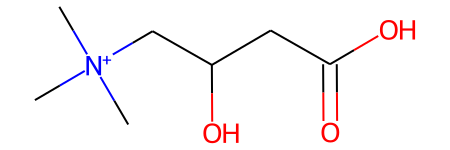

In [3]:
sample_labels = "../data/spec_datasets/sample_labels.tsv"
test_df = pd.read_csv(sample_labels, sep="\t")

# Get first entry from test_df for smiles and ionization
test_smiles = test_df.iloc[0]["smiles"]
test_ionization = test_df.iloc[0]["ionization"]

test_smiles = "InChI=1S/C7H15NO3/c1-8(2,3)5-6(9)4-7(10)11/h6,9H,4-5H2,1-3H3/p+1"
test_smiles = "C[N+](C)(C)CC(CC(=O)O)O"
test_ionization = "[M+H]+"
Chem.MolFromSmiles(test_smiles)

Load models (run quickstart/scarf/download_models.sh first to download)

In [4]:
# Get best models

inten_ckpt = f"../quickstart/scarf/models/canopus_weave_model.ckpt"
gen_ckpt = f"../quickstart/scarf/models/canopus_thread_model.ckpt"

gen_model_obj = scarf_model.ScarfNet.load_from_checkpoint(gen_ckpt)
inten_model_obj = scarf_model.ScarfIntenNet.load_from_checkpoint(inten_ckpt)

# Build joint model class
model = scarf_model.JointModel(
    gen_model_obj=gen_model_obj, inten_model_obj=inten_model_obj
)
model.eval()
model.freeze()
model = model.to("cpu")

In [5]:
# Predict example entry
# Model predict takes both a smiles string and an ionization
output = model.predict_mol(
    test_smiles,
    threshold=0,
    device="cpu",
    max_nodes=300,
    adduct=test_ionization,
    binned_out=False,
)

/mnt/home/samlg/miniforge-pypy3/envs/ms-gen-pred/lib/python3.8/site-packages/dgl/backend/pytorch/tensor.py:44: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630839582/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return th.as_tensor(data, dtype=dtype)


In [6]:
# Add adduct in 
new_masses = [i + common.ion2mass[test_ionization] for i in output['masses']]   
output['masses_charged'] = new_masses

Output contents: 

1. spec: Intensities paired to each formula
2. forms: String formulae
3. masses: Masses of chem formula

Below we show how to sum all intensities according to mz in order to generate a single spectrum. Note that if binned predictions are desired, the model should be adjusted by setting "binnned_out=True", which will be more accurate, as it uses attentive pooling. Here we take a heuristic explanation for each peak and take _max_ pooling over formulae with equivalent masses.

In [7]:
# Convert from frags dict into a list of mz, inten
mass_to_obj = defaultdict(lambda: {})
for m, i, form in zip(output['masses_charged'], output['spec'], output['forms']):
    if i <= 0:
        continue
    cur_obj = mass_to_obj[m]
    if i > cur_obj.get("inten", 0):
        cur_obj["formula"] = form
        cur_obj["inten"] = i

max_inten = max(*[i["inten"] for i in mass_to_obj.values()], 1e-9)
mass_to_obj = {
    k: dict(inten=v["inten"] / max_inten, formula=v["formula"])
    for k, v in mass_to_obj.items()
}

In [8]:
sorted(list(mass_to_obj.items()), key = lambda x: x[1]["inten"], reverse=True)[:10]

[(103.099165456, {'inten': 1.0, 'formula': 'C5NOH12'}),
 (102.091340424, {'inten': 0.88081044, 'formula': 'C5NOH11'}),
 (85.064791328, {'inten': 0.41944608, 'formula': 'C5OH8'}),
 (99.067865328, {'inten': 0.19598472, 'formula': 'C5NOH8'}),
 (100.07569036, {'inten': 0.17955087, 'formula': 'C5NOH9'}),
 (58.065125675999994, {'inten': 0.1304368, 'formula': 'C3NH7'}),
 (60.08077573999999, {'inten': 0.11260316, 'formula': 'C3NH9'}),
 (44.049475611999995, {'inten': 0.11138921, 'formula': 'C2NH5'}),
 (70.065125676, {'inten': 0.1027039, 'formula': 'C4NH7'}),
 (71.072950708, {'inten': 0.07412808, 'formula': 'C4NH8'})]

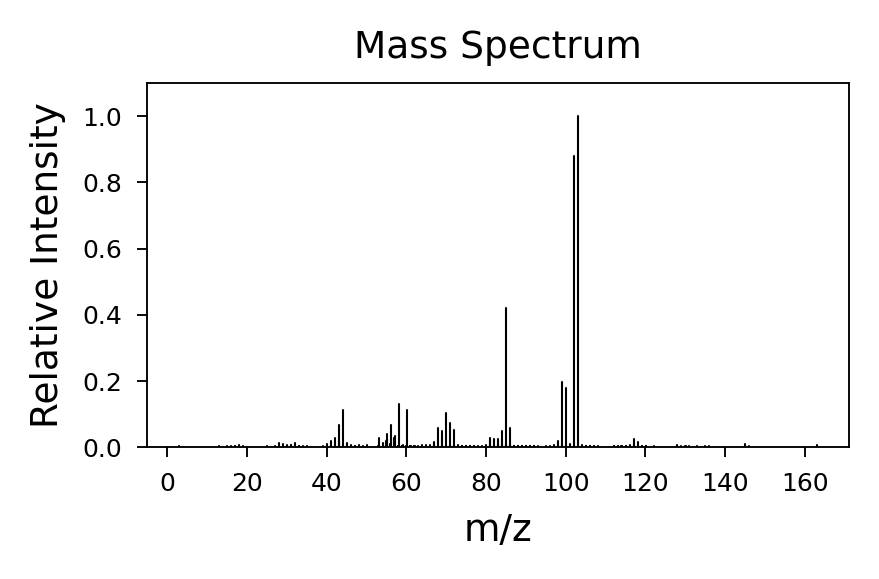

In [9]:
# Plot the output
fig = plt.figure(figsize=(3, 2), dpi=300)
for k, v in mass_to_obj.items():
    # Plot verticle line from k to v['inten']
    plt.plot([k, k], [0, v["inten"]], color="black", linewidth=0.5)
    # Can also get the frag id if we want to plot one of these in particular

plt.xlabel("m/z")
plt.ylabel("Relative Intensity")
plt.title("Mass Spectrum")
# Set ylim
plt.ylim(0, 1.1)
plt.tight_layout()